## Set up


In [5]:
# --- CELL 1: Setup & Imports ---
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import lstm_model # Your python file
import os

# Go up two directories (../../) to reach the root, then into Data
train_folder = "../../Data/Train_Test_Data/Not_Seperated/Clips_Split_80_20/Train_clips"
test_folder = "../../Data/Train_Test_Data/Not_Seperated/Clips_Split_80_20/Test_clips" 

# Quick sanity check! This should print True if the paths are correct.
print("Train folder found:", os.path.exists(train_folder))
print("Test folder found:", os.path.exists(test_folder))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Train folder found: True
Test folder found: True
Using device: cpu


## Data Preparation

In [6]:
# --- CELL 2: Data Preparation ---
window_size = 5
batch_size = 16

print("Loading training data...")
train_dataset = lstm_model.PoseWindowDataset(train_folder, window_size=window_size)

print("Loading validation data...")
# MUST pass the train_dataset.label_encoder here!
test_dataset = lstm_model.PoseWindowDataset(test_folder, window_size=window_size, label_encoder=train_dataset.label_encoder)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.label_encoder.classes_)
print(f"\n✅ Ready! Classes ({num_classes}): {train_dataset.label_encoder.classes_}")

Loading training data...
Loading validation data...

✅ Ready! Classes (14): ['cross' 'crouching_low_sweep' 'grab' 'hadouken' 'idle' 'jab'
 'jumping_cross' 'lead_hook' 'rear_hook' 'rear_low_kick' 'shoryuken'
 'side_kick' 'spinning_back_high_kick' 'uppercut']


## Training Set up

In [7]:
# --- CELL 3: Tracked Training Loop ---
def train_and_tune(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        # 1. Training Phase
        model.train()
        running_train_loss = 0.0
        
        for seq, label in train_loader:
            seq, label = seq.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * seq.size(0)
            
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # 2. Validation Phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for seq, label in val_loader:
                seq, label = seq.to(device), label.to(device)
                val_output = model(seq)
                val_loss = criterion(val_output, label)
                running_val_loss += val_loss.item() * seq.size(0)
                
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1:02d}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        
    return train_losses, val_losses

## Training Model

In [8]:
# --- CELL 4: Run Training ---
# Initialize your specific model
model = lstm_model.LSTMWindowClassifier(
    input_size=84, 
    hidden_size=128,  # Try changing this! (e.g., 64, 256)
    num_layers=2,     # Try changing this!
    num_classes=num_classes,
    dropout=0.3
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Try tweaking the learning rate

epochs_to_run = 15

print("Starting training...")
train_hist, val_hist = train_and_tune(model, train_loader, val_loader, criterion, optimizer, epochs=epochs_to_run)

Starting training...
Epoch 01/15 | Train Loss: 1.3078 | Val Loss: 0.9994
Epoch 02/15 | Train Loss: 0.8704 | Val Loss: 0.8910
Epoch 03/15 | Train Loss: 0.6798 | Val Loss: 0.7129
Epoch 04/15 | Train Loss: 0.5659 | Val Loss: 0.5783
Epoch 05/15 | Train Loss: 0.4788 | Val Loss: 0.5750
Epoch 06/15 | Train Loss: 0.4220 | Val Loss: 0.4994
Epoch 07/15 | Train Loss: 0.3689 | Val Loss: 0.4203
Epoch 08/15 | Train Loss: 0.3302 | Val Loss: 0.4723
Epoch 09/15 | Train Loss: 0.2967 | Val Loss: 0.5562
Epoch 10/15 | Train Loss: 0.2802 | Val Loss: 0.4810
Epoch 11/15 | Train Loss: 0.2618 | Val Loss: 0.4874
Epoch 12/15 | Train Loss: 0.2382 | Val Loss: 0.5154
Epoch 13/15 | Train Loss: 0.2278 | Val Loss: 0.4800
Epoch 14/15 | Train Loss: 0.2142 | Val Loss: 0.4948
Epoch 15/15 | Train Loss: 0.2028 | Val Loss: 0.4721


## Model Evaluation

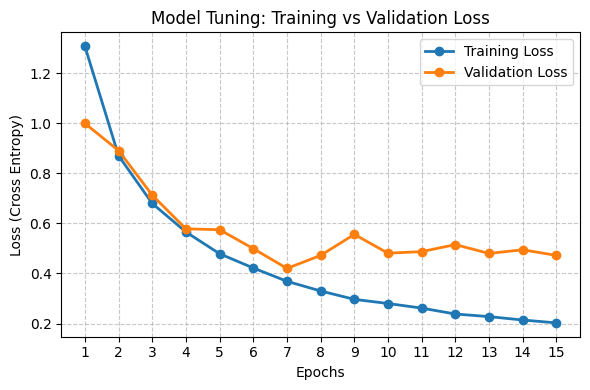

In [10]:
# --- CELL 5: Plot Learning Curves ---
plt.figure(figsize=(6, 4)) 
plt.plot(range(1, epochs_to_run + 1), train_hist, label='Training Loss', marker='o', linewidth=2)
plt.plot(range(1, epochs_to_run + 1), val_hist, label='Validation Loss', marker='o', linewidth=2)

plt.title('Model Tuning: Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, epochs_to_run + 1))
plt.tight_layout()
plt.show()